# Boxplots

## Script setup

In [28]:
# Third-party and standard modules
from typing import Dict, Hashable, Union, Tuple
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from collections import defaultdict
from numpy import NINF
from importlib import reload

# User-defined modules.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is used to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script parameters

The following values are this script's parameters.

In [29]:
filepath = './cisco_wifi_data_until_20190513.csv'
timezone = pytz.timezone('US/Pacific')
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries
buildings = [
    'SCC', 'HAHN', 'CROOKSHANK', 'THATHCHER', 'CLARK',
    'CARNEGIE', 'MASON', 'PEARSON', 'ALEXANDER', 'ITB'
]

## Data Processing

In [30]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [31]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))

# We must assume that intervening na-values are 0's.
occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)

In [32]:
# Group columns (access points) by building.
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [33]:
print('buildings not found: {}'.format(
    set(buildings) - set(occ_bybuild.groups.keys())
))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())

buildings not found: {'CROOKSHANK', 'PEARSON', 'THATHCHER'}


In [34]:
# We need the total occupancy timeseries for each building.
build_to_totals: Dict[Hashable, pd.Series] = {}

# We need to find the maximum occupancy for a building at
# any point in time to normalize the y-axes of the boxplots below.
max_totals: Dict[Hashable, float] = defaultdict(lambda: NINF)

for build in buildings:
    # get the total occupancy timeseries just for this building.
    build_totals = build_to_totals[build] = dfm.row_totals(
        occ_bybuild.get_group(build)
    )
    # search for a new max.
    newmax = build_totals.max().squeeze()
    if newmax > max_totals[build]:
        max_totals[build] = newmax

## Boxplots

In [35]:
def display_and_save_hourly_boxplot(
    tseries: pd.Series, title: str,
    xlabel: str, ylabel: str, ymax: Union[float, int],
    figsize: Tuple[Union[float,int], Union[float,int]],
    figfilepath: str
) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, ymax)
    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=tseries.index.hour,
        # The total occupancy at that hour.
        y=tseries,
        ax=ax
    )
    fig.savefig(figfilepath)

/Users/josalvatorre/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


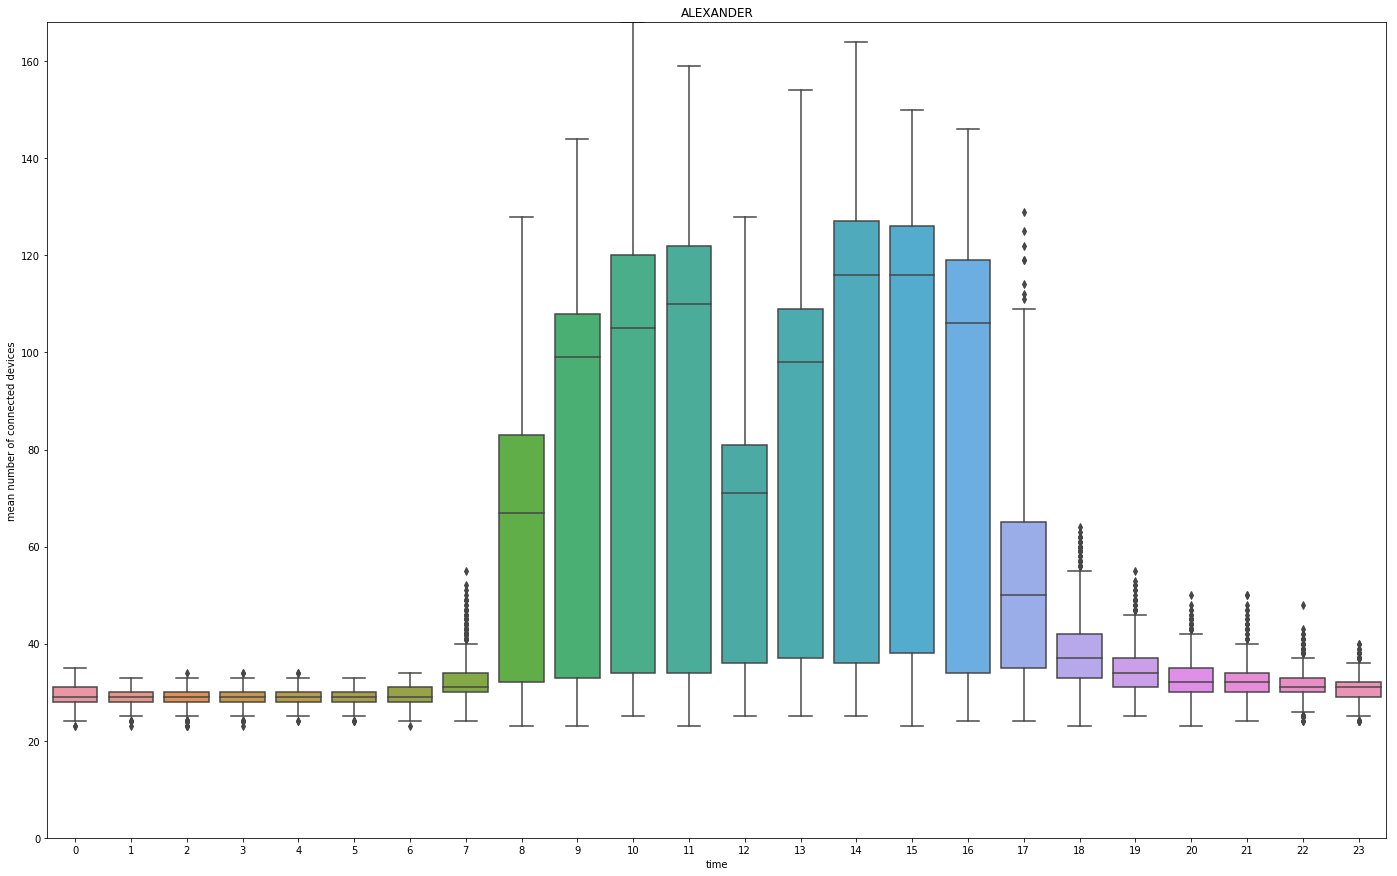

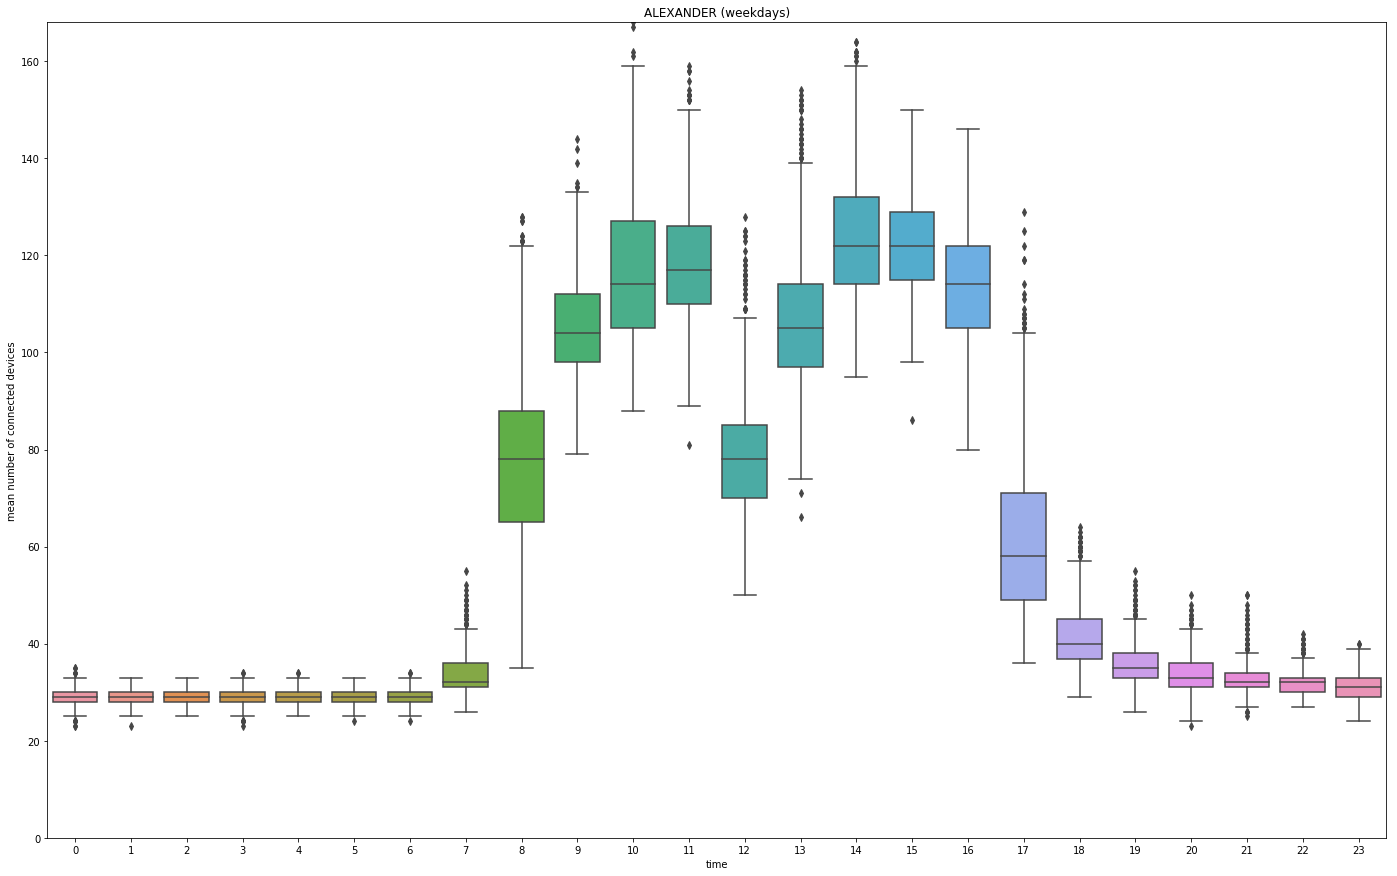

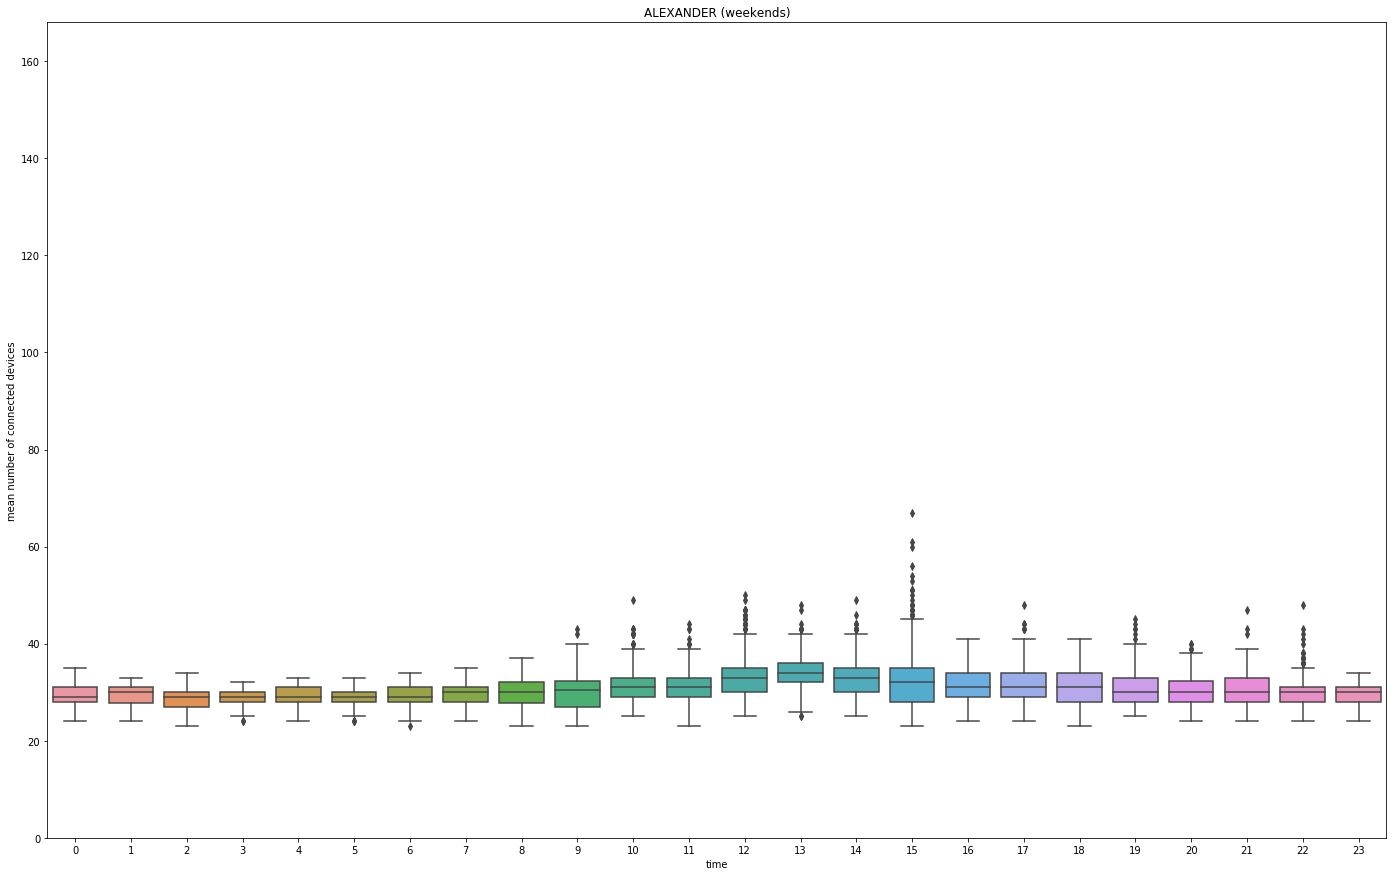

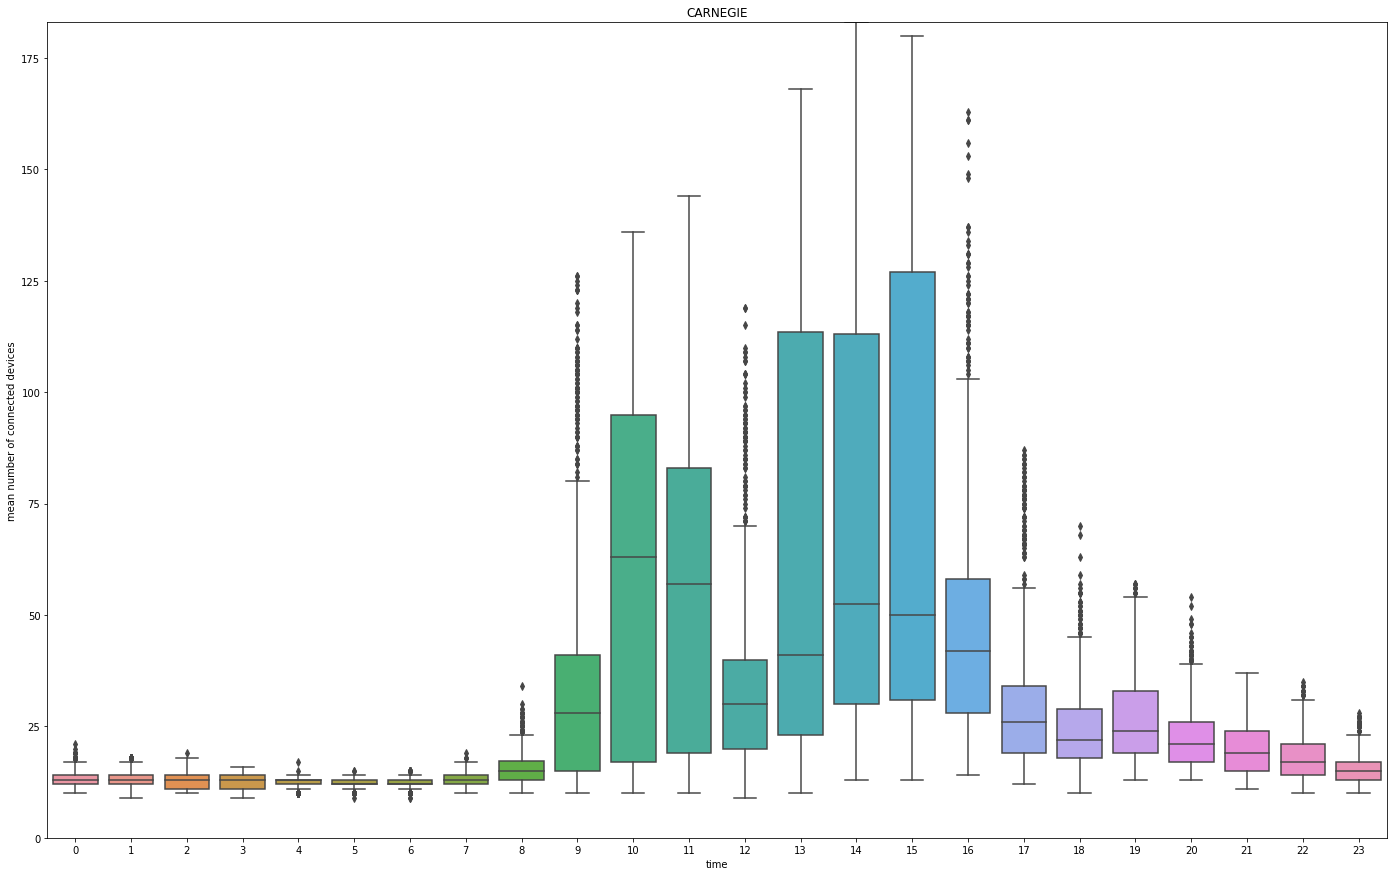

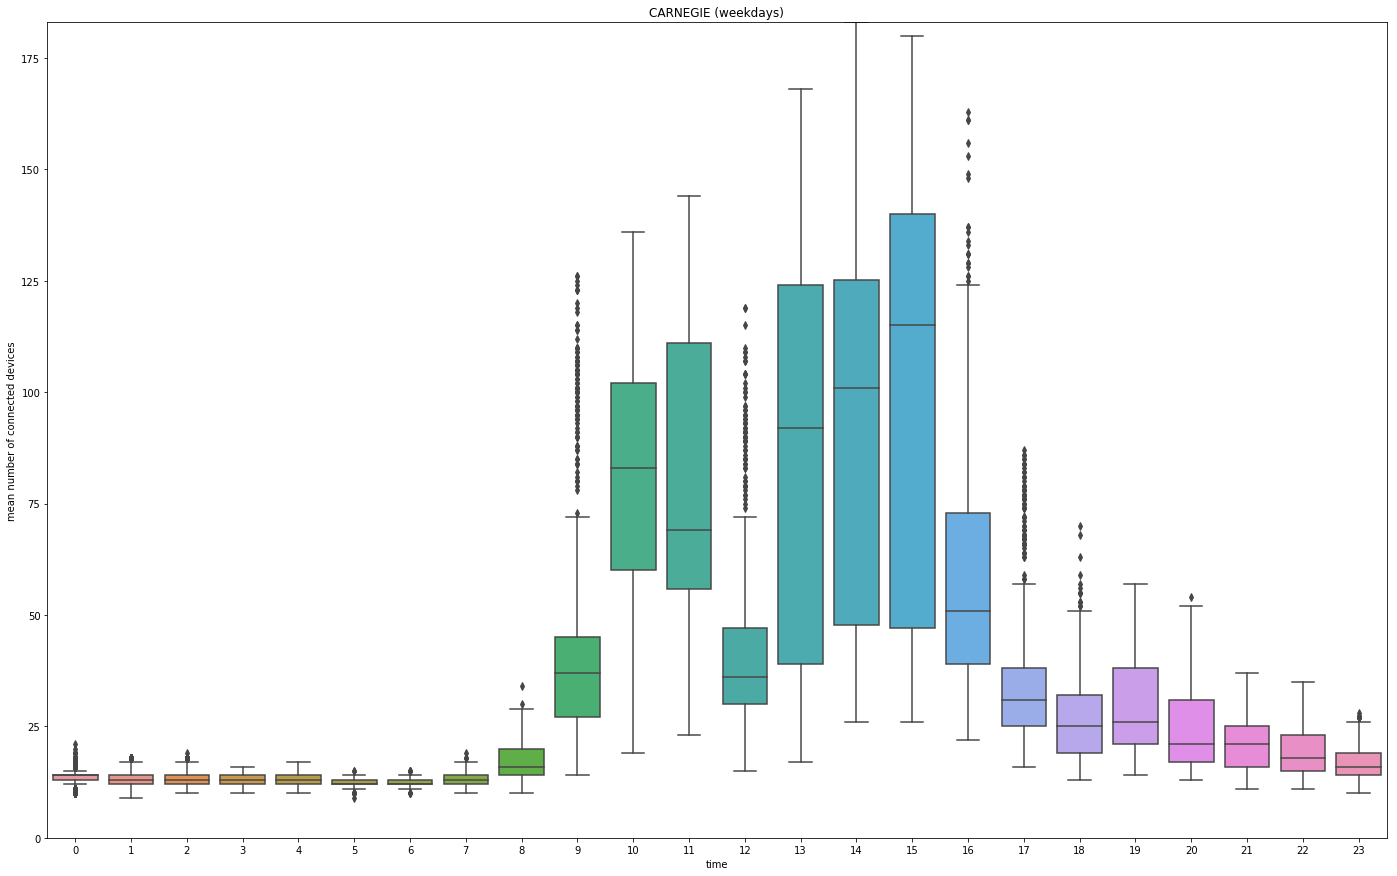

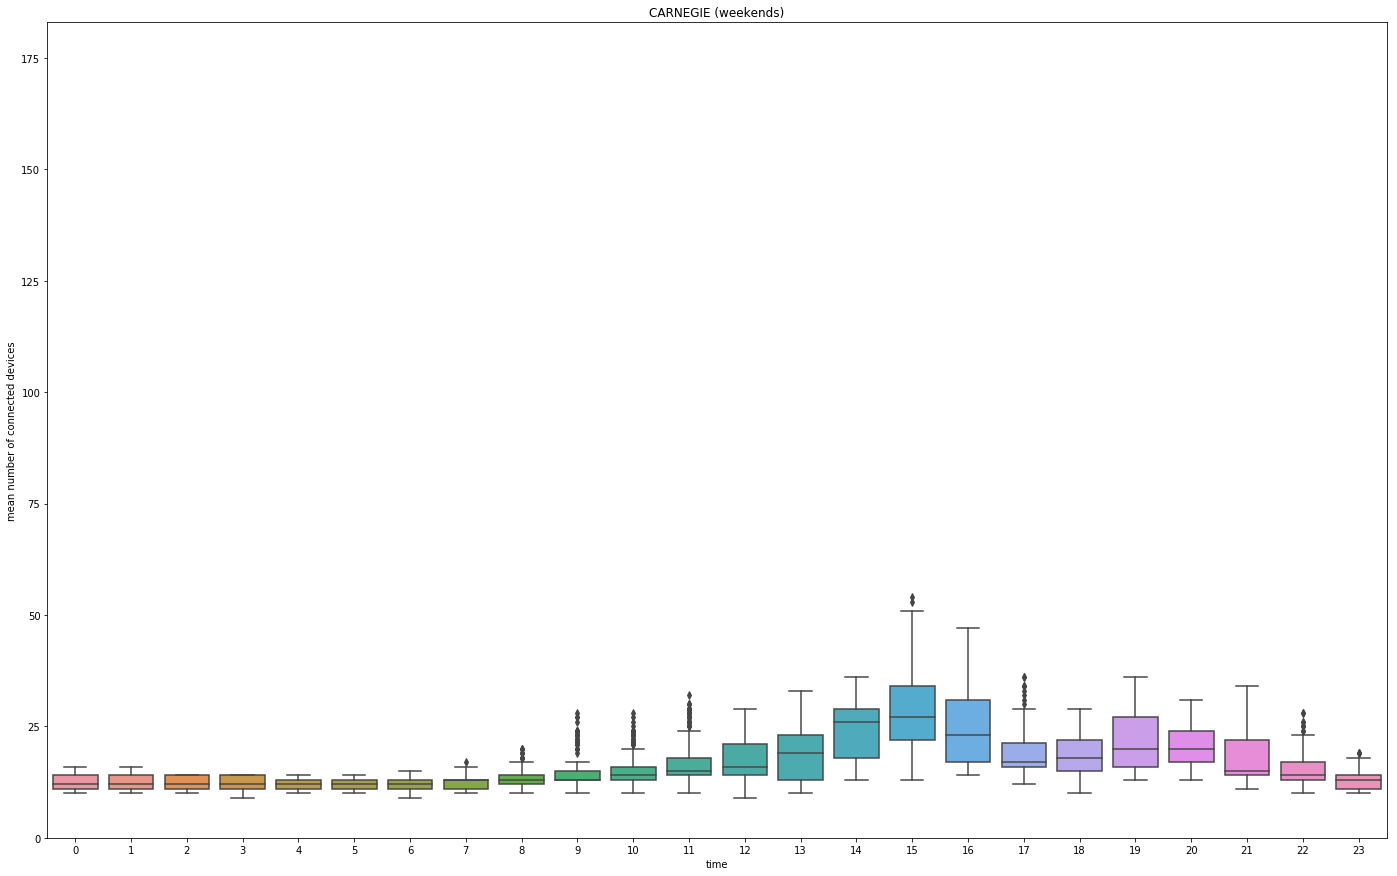

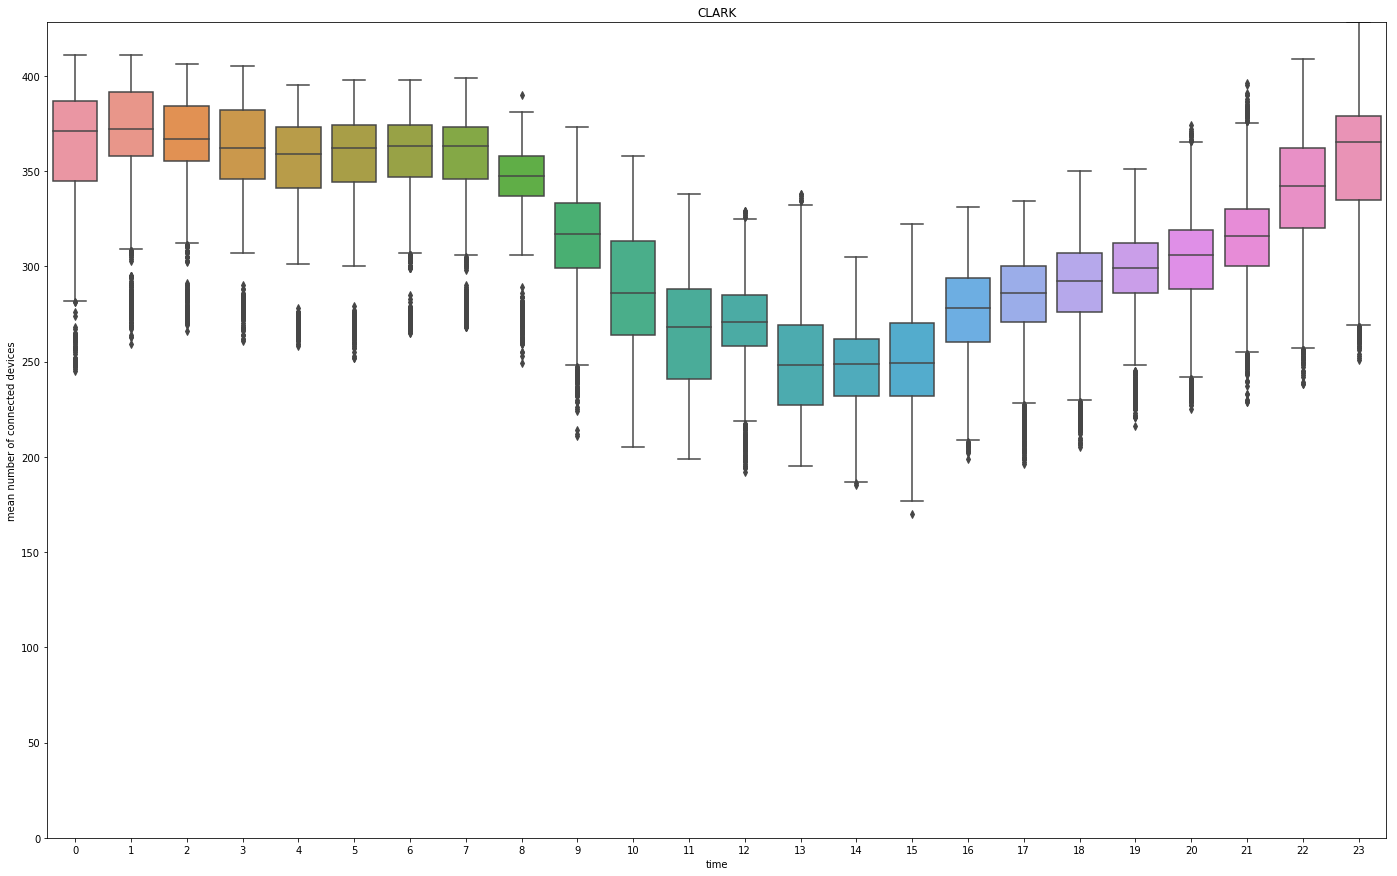

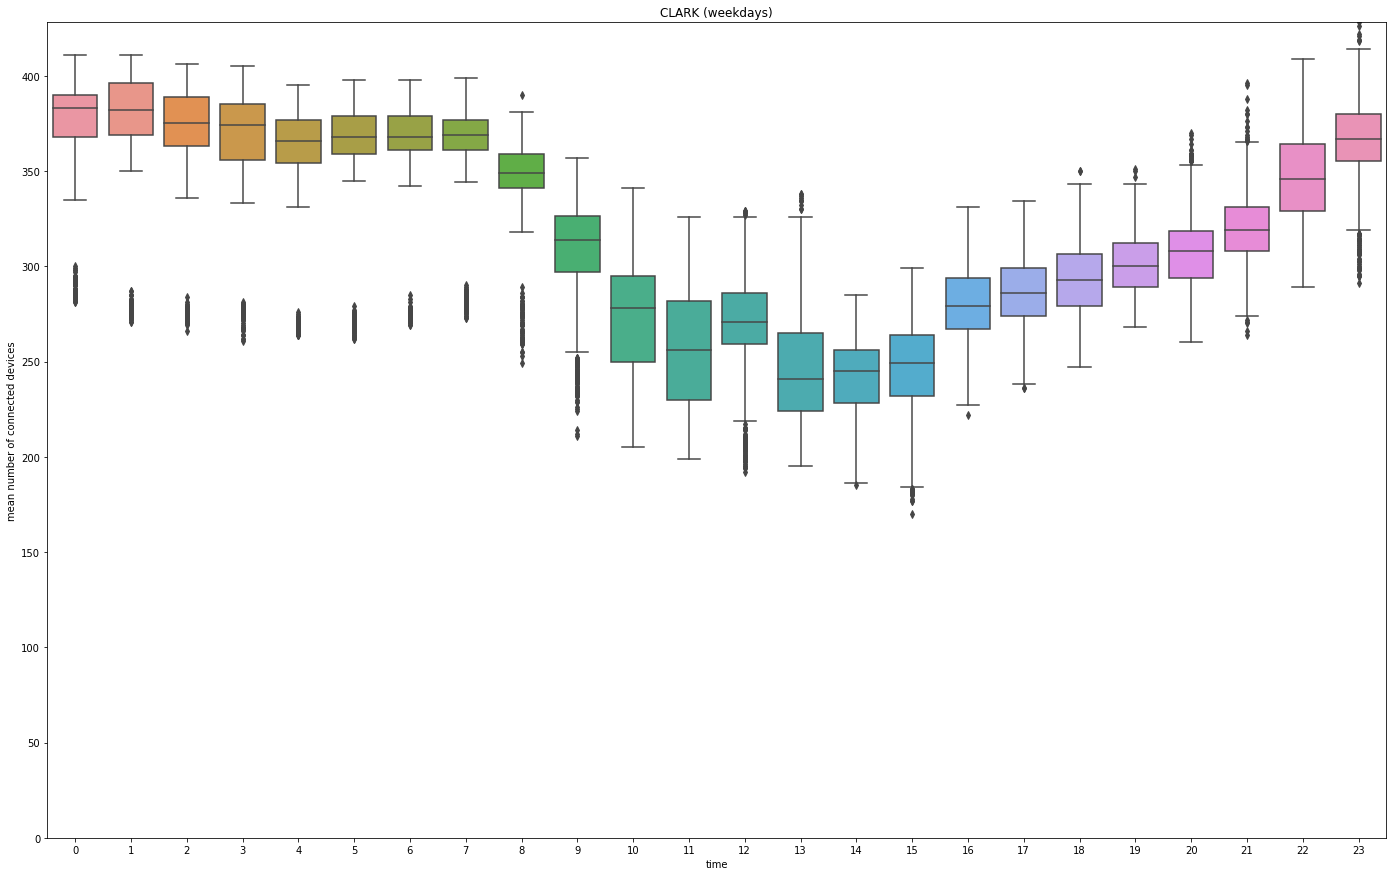

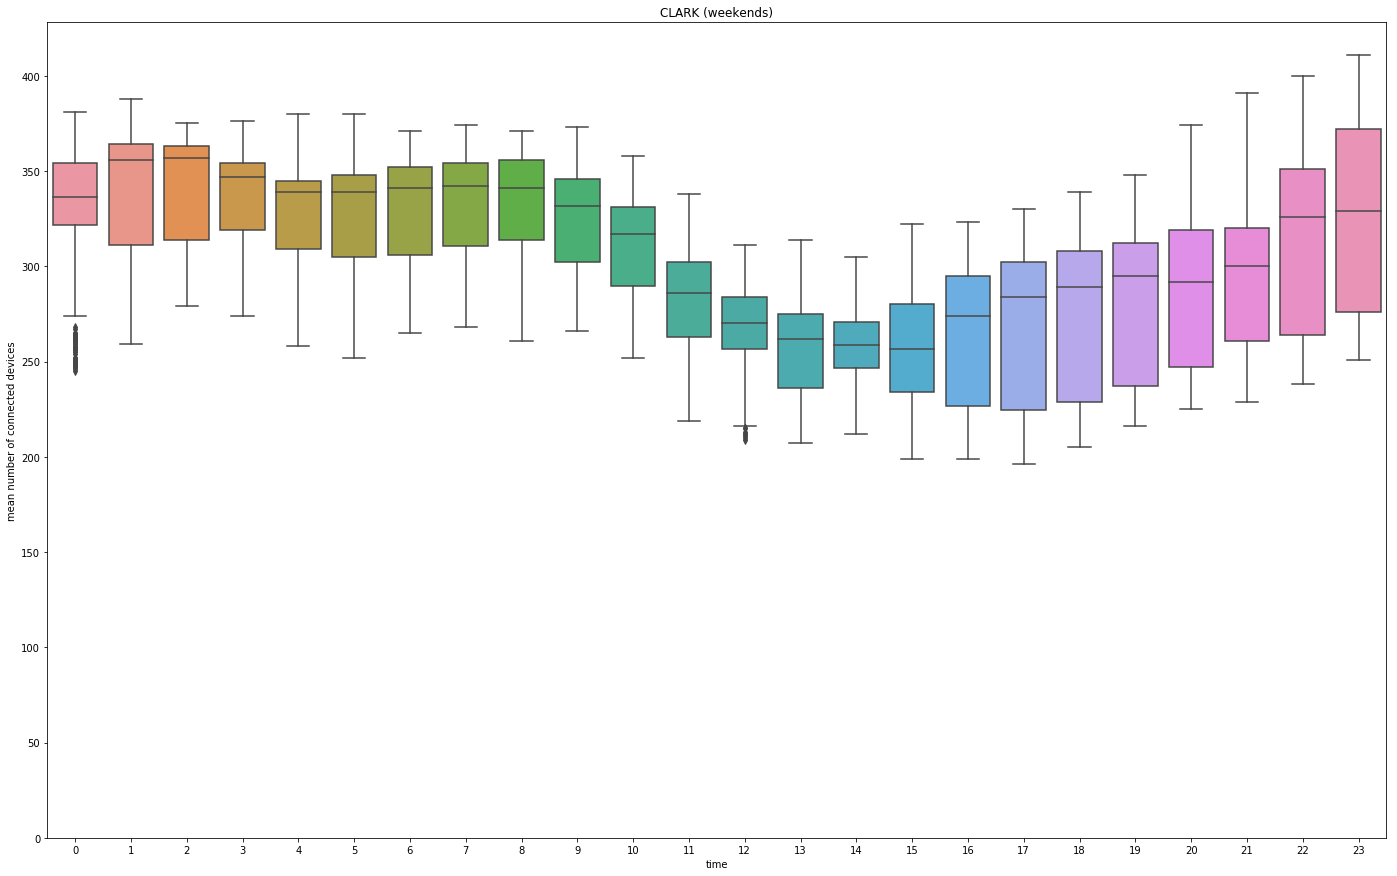

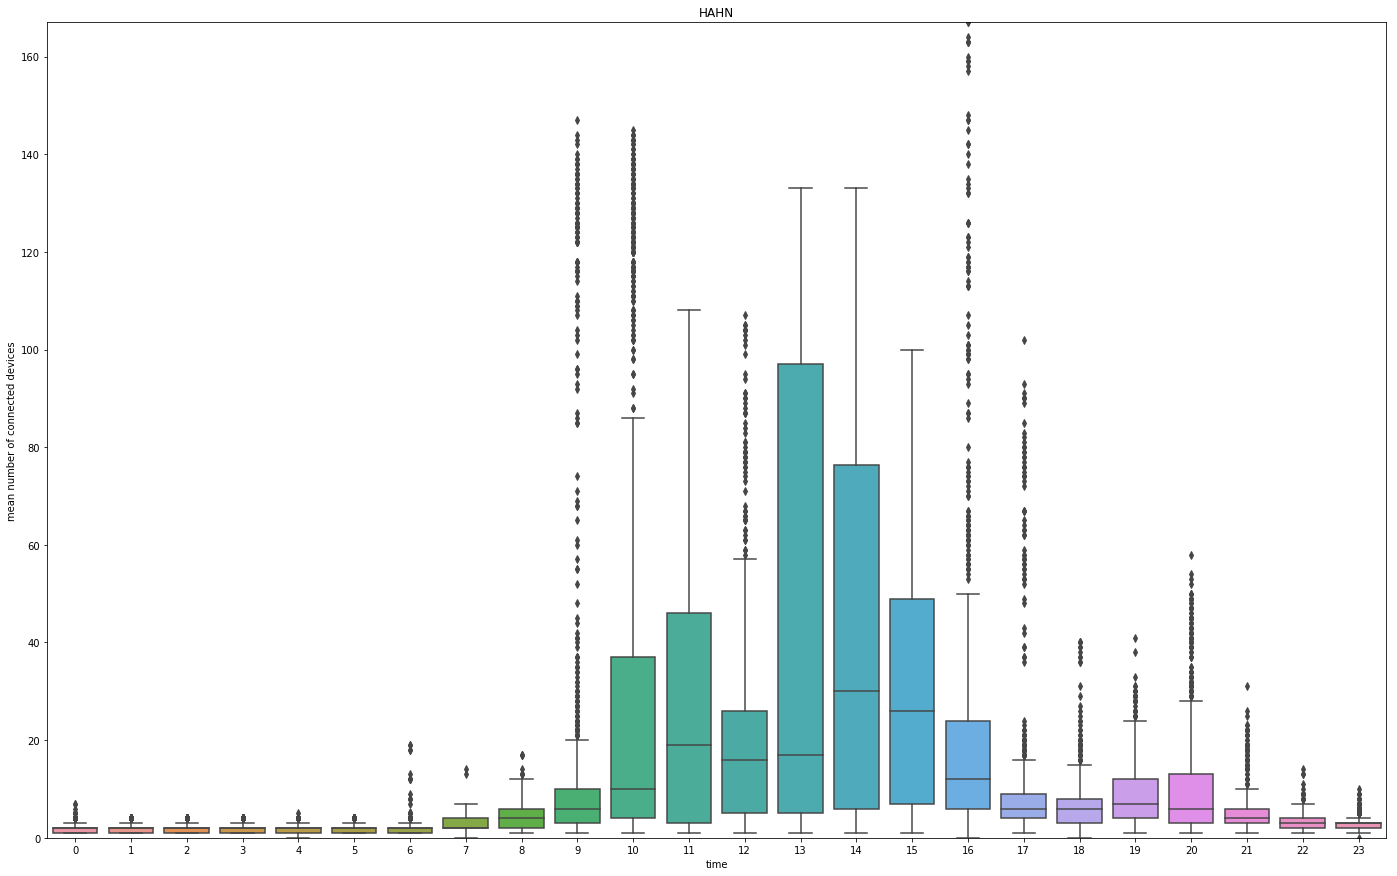

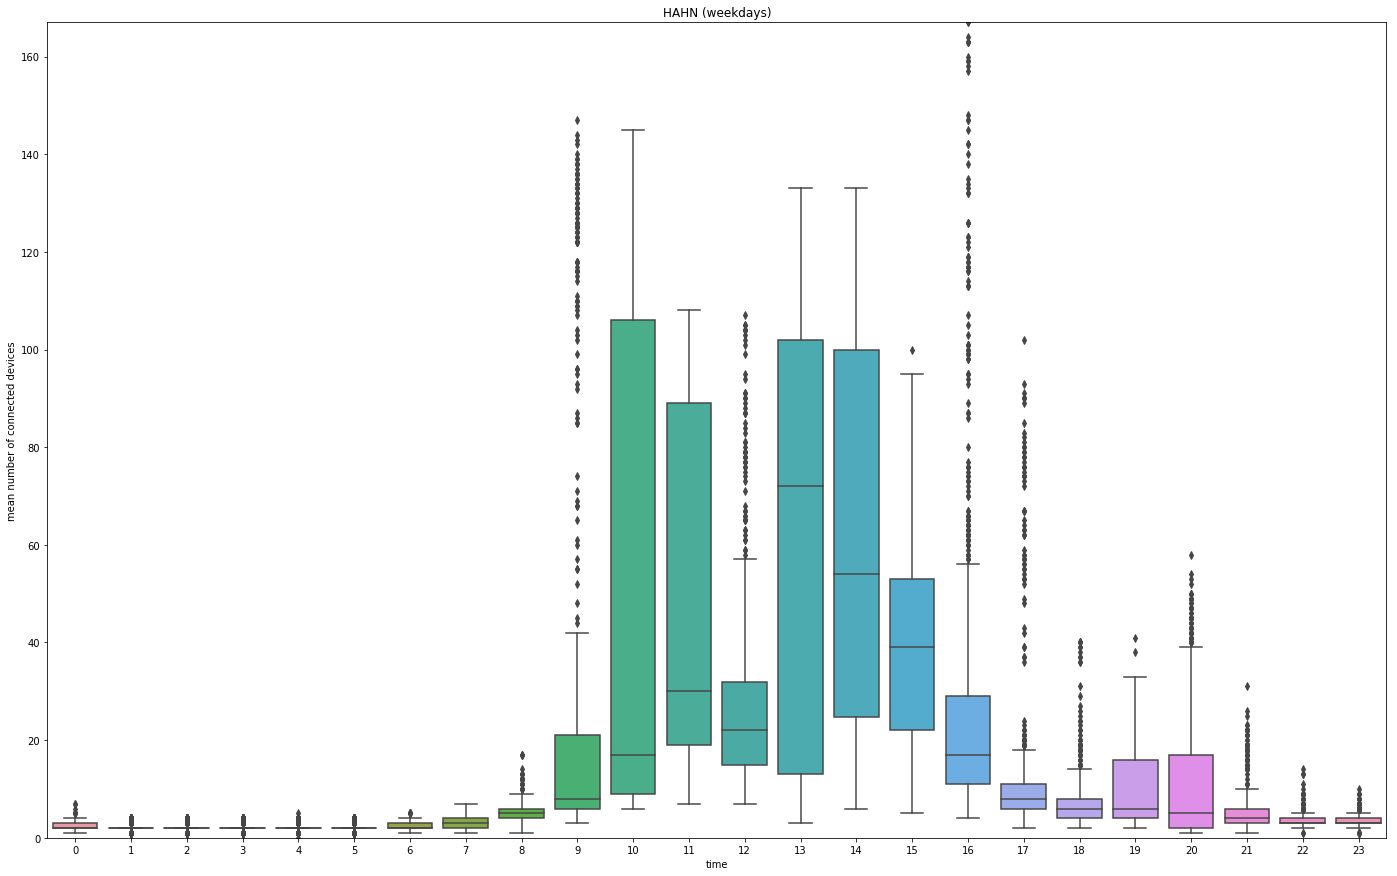

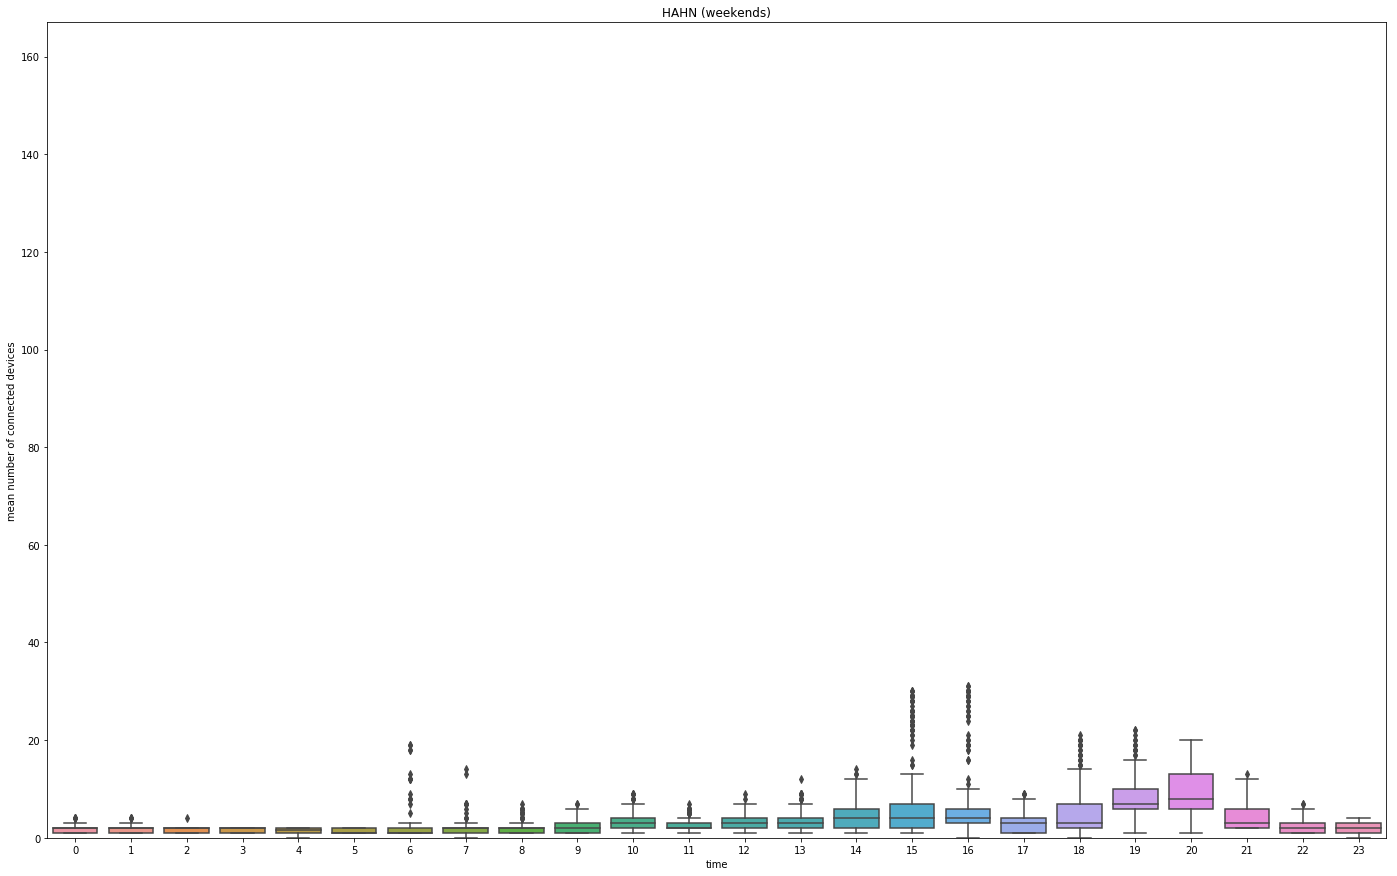

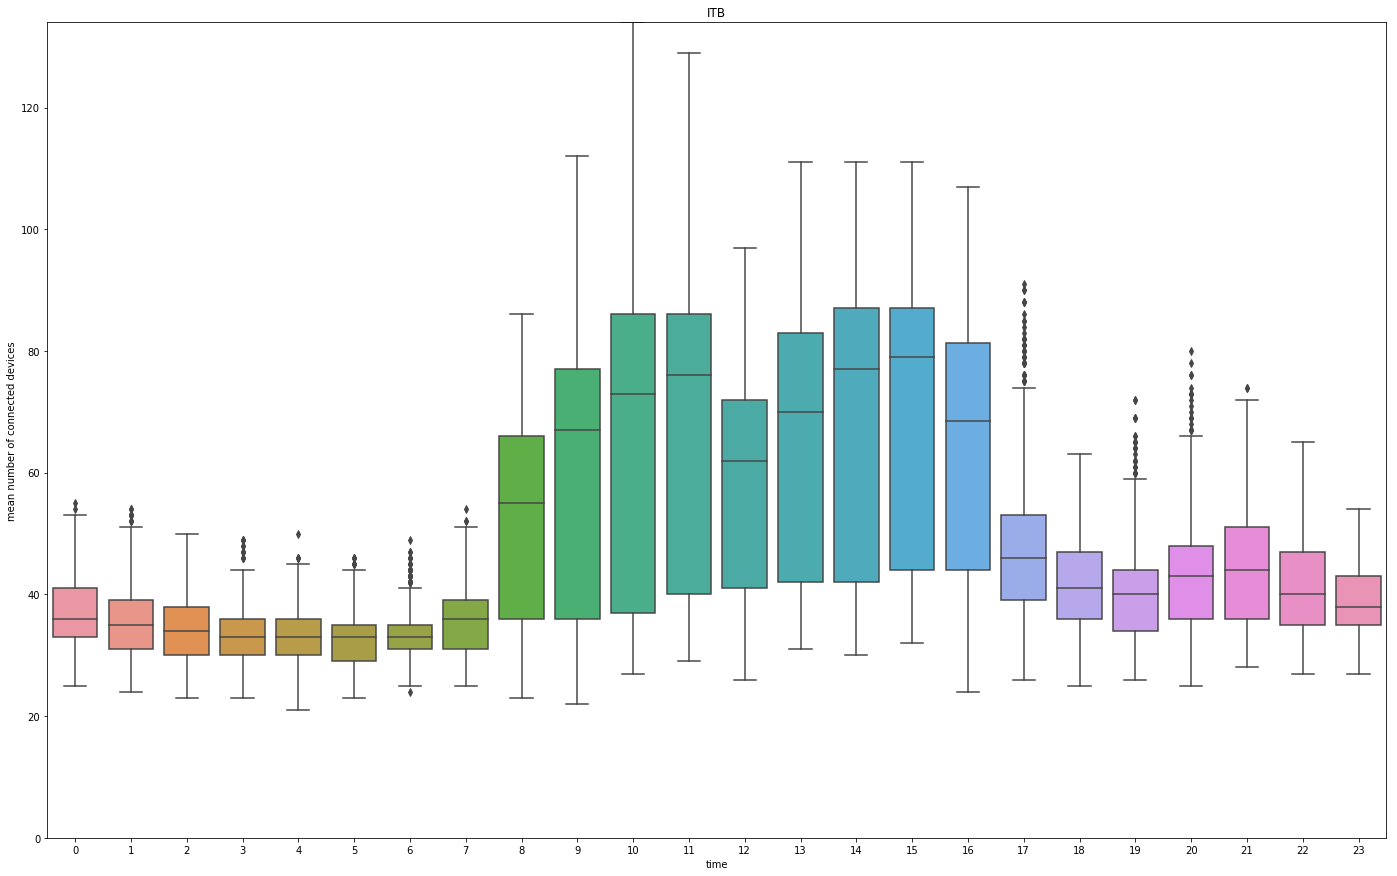

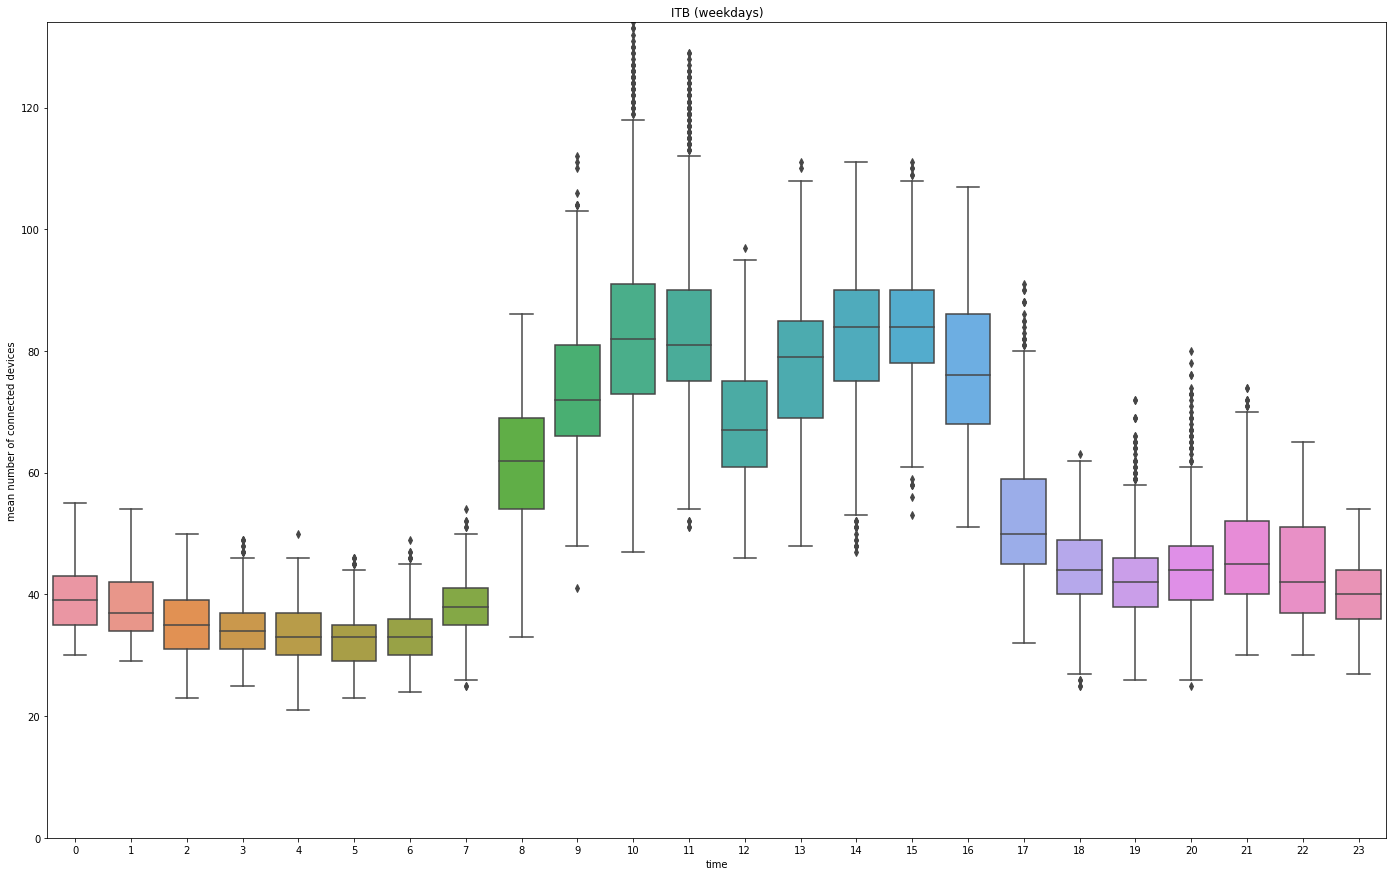

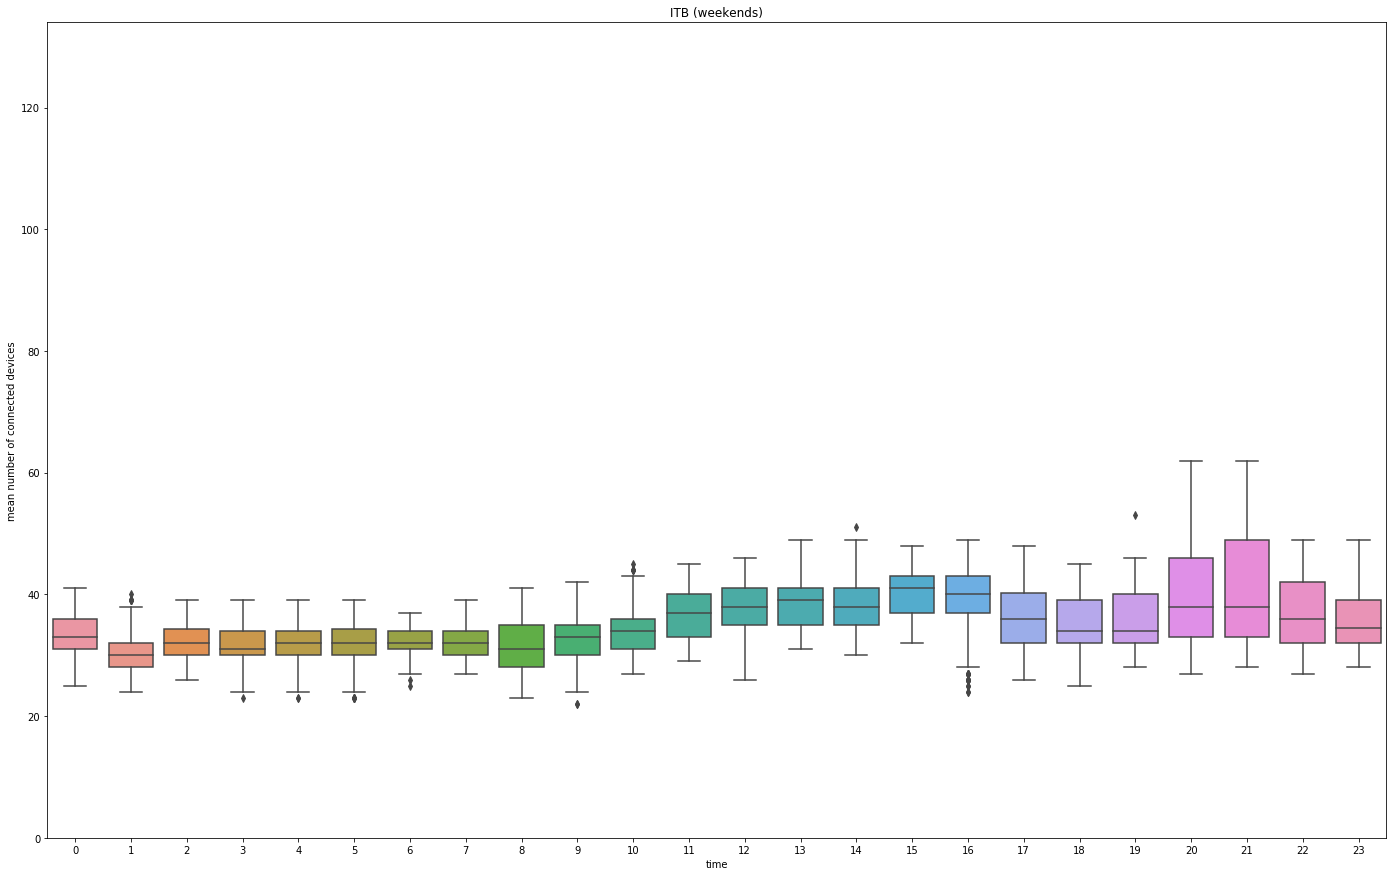

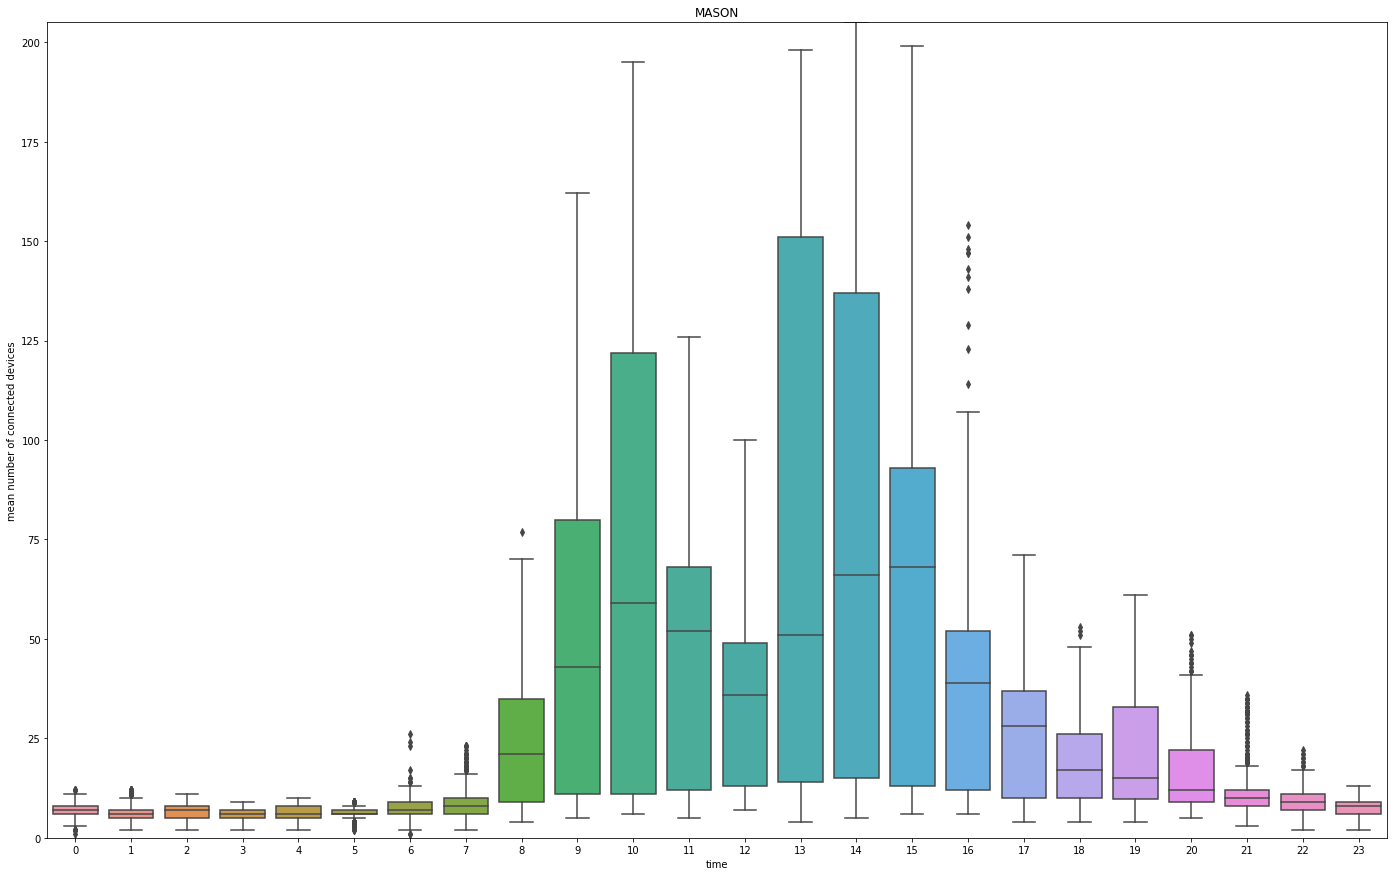

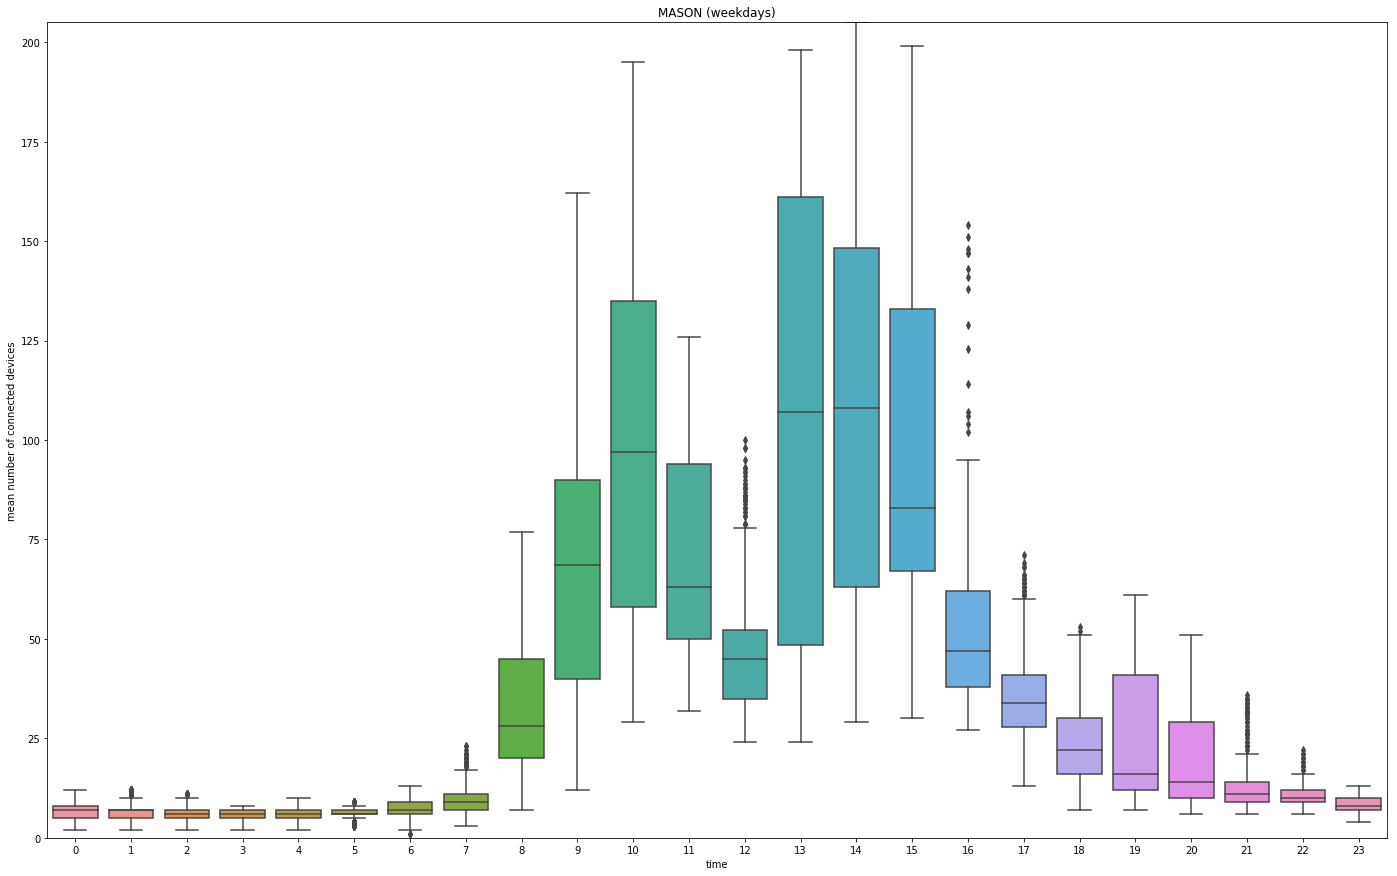

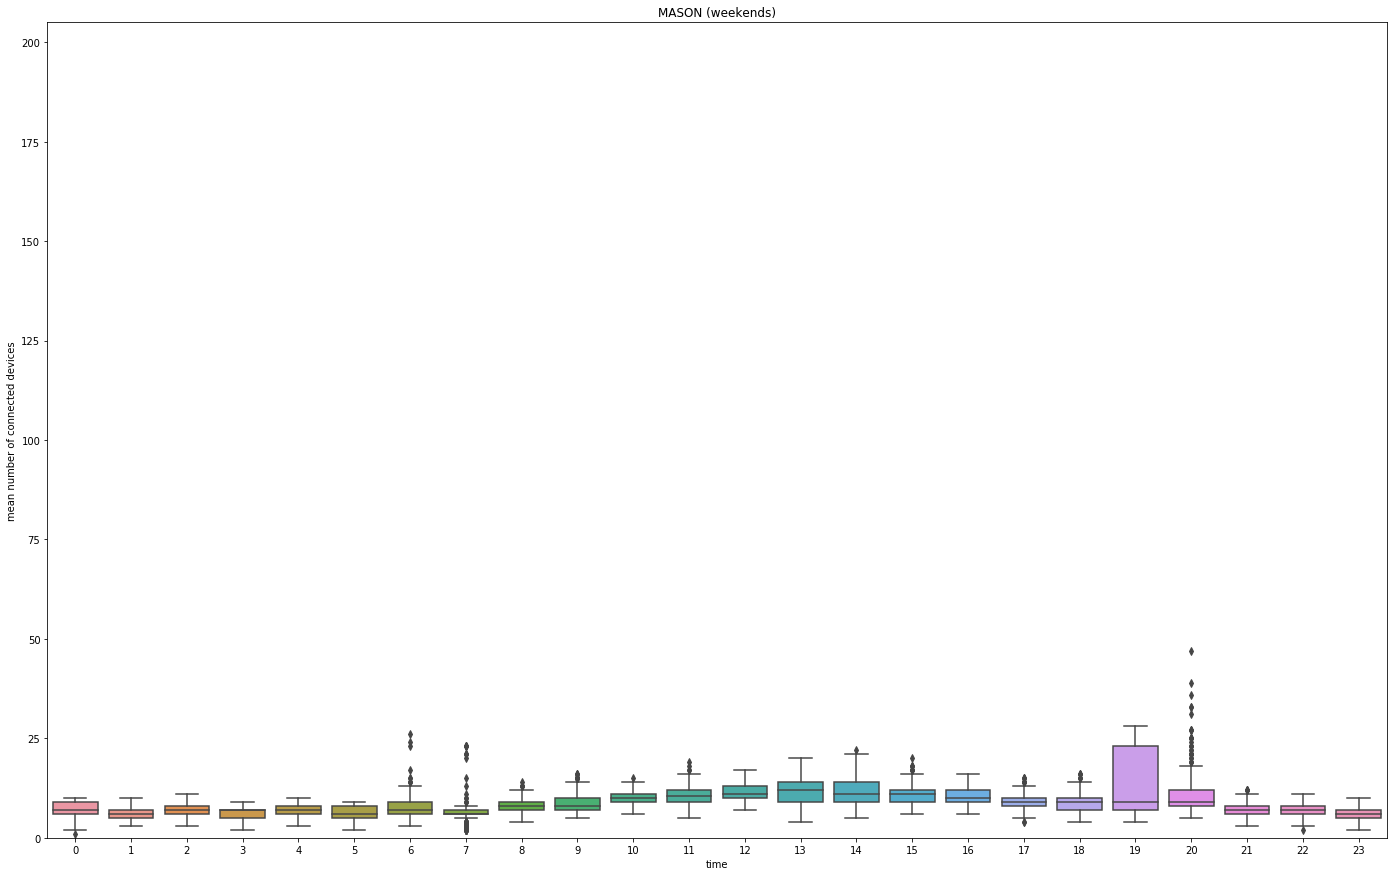

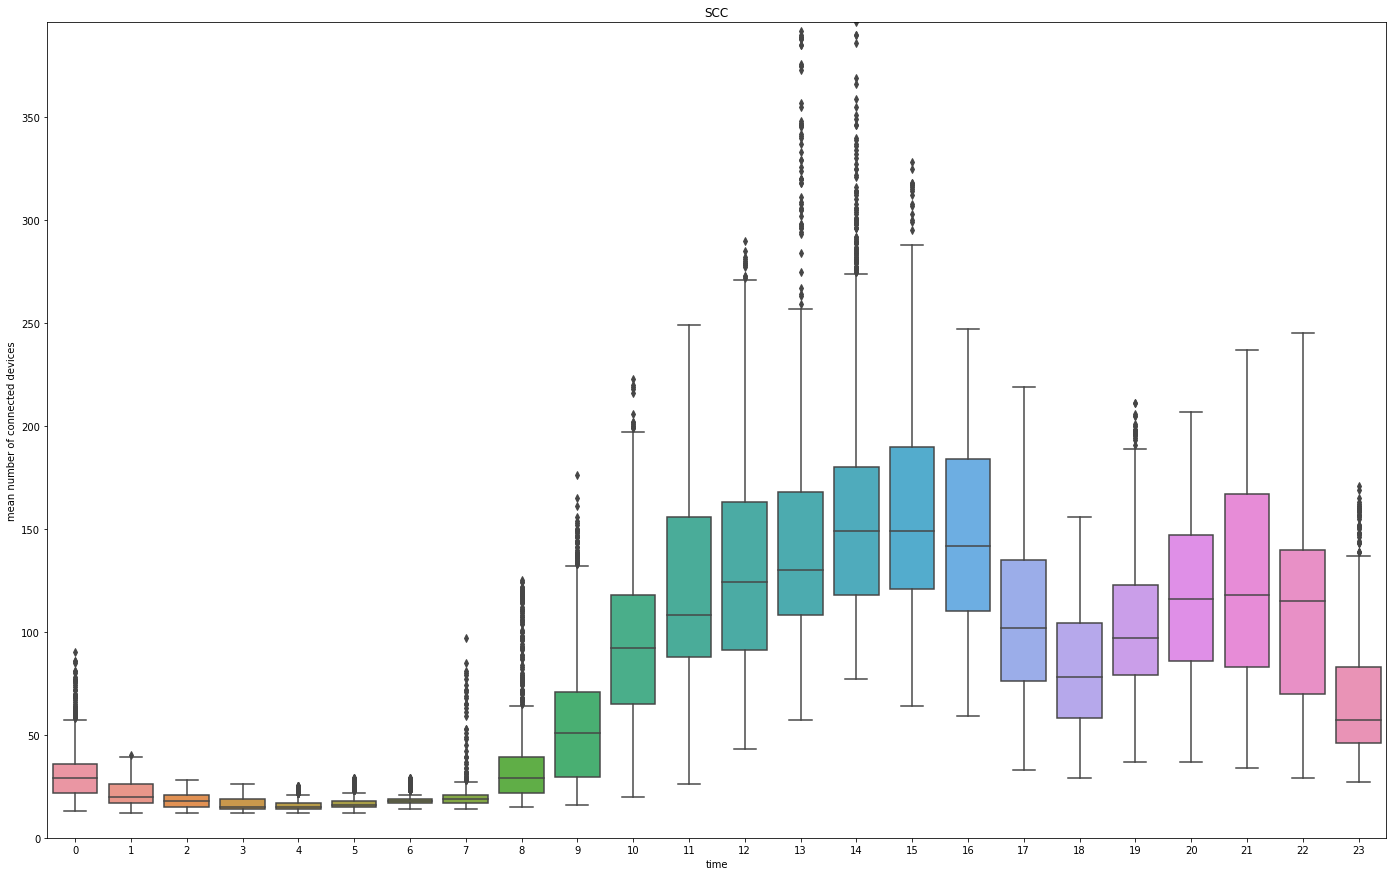

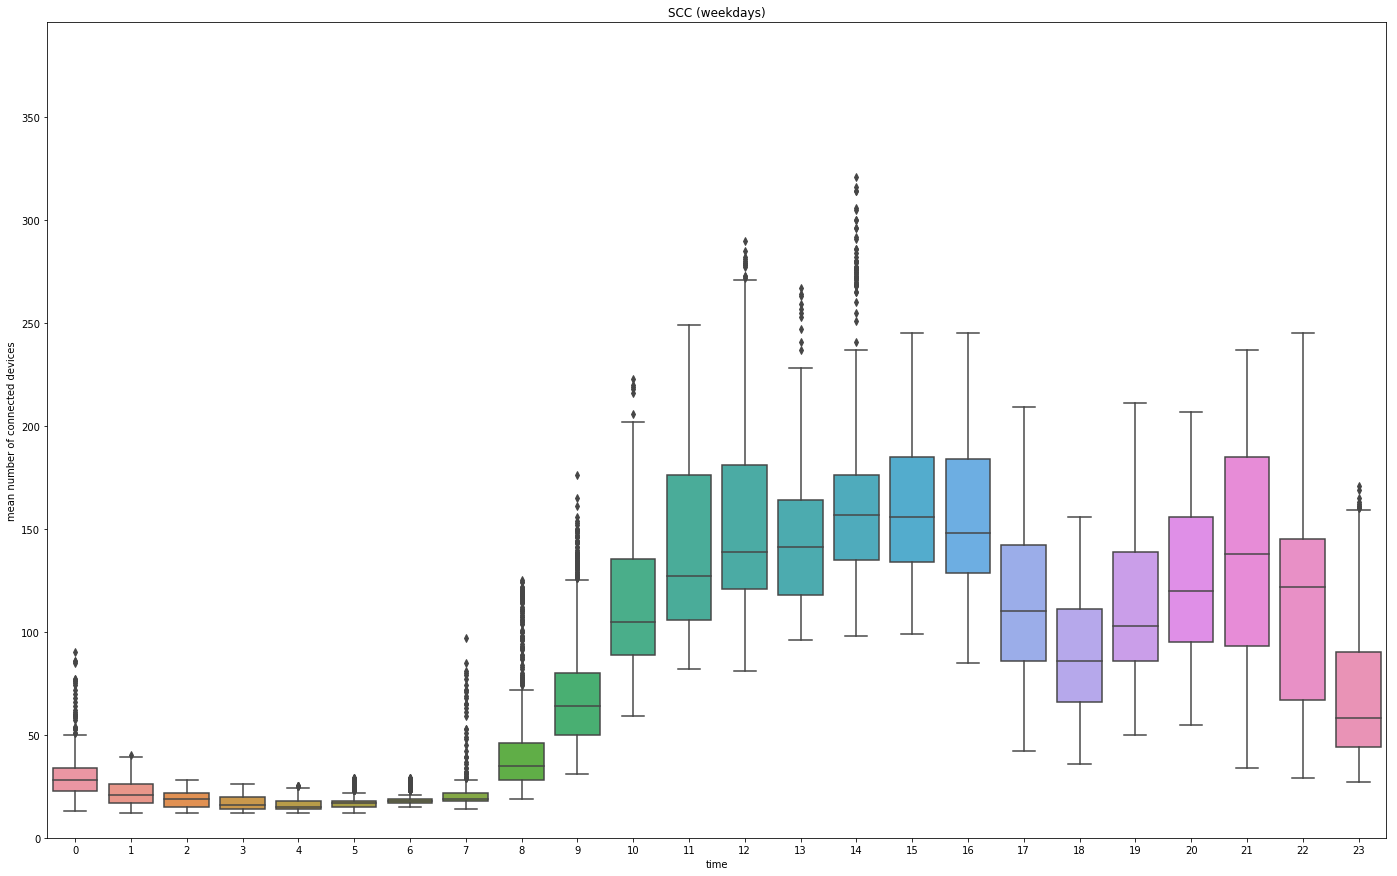

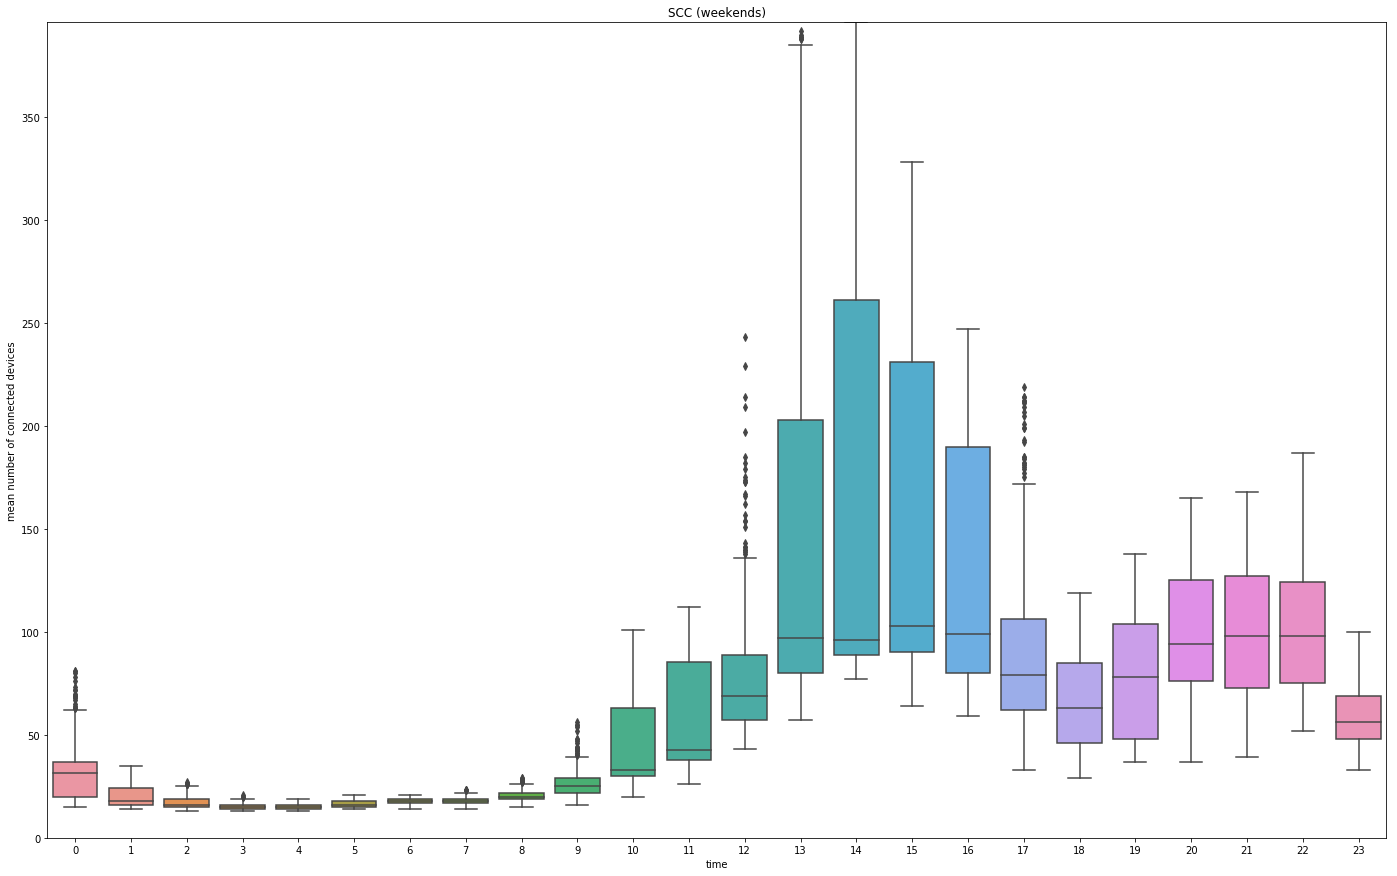

In [36]:
for build in buildings:
    # get the total occupancy timeseries just for this building.
    build_totals: pd.DataFrame = build_to_totals[build]

    common_args = {
        'xlabel': 'hour of the day',
        'ylabel': 'mean number of connected devices',
        'ymax': max_totals[build], 
        'figsize': (24, 15)
    }

    # Overall boxplot.
    display_and_save_hourly_boxplot(
        tseries=build_totals,
        title=build,
        figfilepath='./{}.png'.format(build),
        **common_args
    )
    # Weekdays boxplot.
    display_and_save_hourly_boxplot(
        tseries=build_totals.loc[build_totals.index.dayofweek < 5],
        title=build+' (weekdays)',
        figfilepath='./{}-wkdays.png'.format(build),
        **common_args
    )
    # Weedends boxplot.
    display_and_save_hourly_boxplot(
        tseries=build_totals.loc[build_totals.index.dayofweek >= 5],
        title=build+' (weekends)',
        figfilepath='./{}-wkends.png'.format(build),
        **common_args
    )